In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path
import sys
import os 

In [2]:
# Leemos el archivo CSV con odos los stocks históricos.
# Usamos ';' como separador, y dayfirst=True para el formato de fecha europeo.
df = pd.read_csv('data/AllStocksHistoricalData.csv', sep=';', parse_dates=['Fecha'], dayfirst=True)

# Visualiza las primeras filas para comprobar que todo está bien
print(df.head())

# Opcional: información básica del dataframe
print(df.info())

       Fecha Symbol    Open   Close    High     Low  AdjClose     Volume
0 1999-12-31   AMZN  3.9656  3.8063  3.9688  3.8000    3.8063  145414000
1 2000-01-03   AMZN  4.0750  4.4688  4.4781  3.9523    4.4688  322352000
2 2000-01-04   AMZN  4.2688  4.0969  4.5750  4.0875    4.0969  349748000
3 2000-01-05   AMZN  3.5250  3.4875  3.7562  3.4000    3.4875  769148000
4 2000-01-06   AMZN  3.5656  3.2781  3.6344  3.2000    3.2781  375040000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326400 entries, 0 to 326399
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Fecha     326400 non-null  datetime64[ns]
 1   Symbol    326400 non-null  object        
 2   Open      326400 non-null  float64       
 3   Close     326400 non-null  float64       
 4   High      326400 non-null  float64       
 5   Low       326400 non-null  float64       
 6   AdjClose  326400 non-null  float64       
 7   Volume    326400 non-nul

In [3]:
# Compruebamos si hay valores nulos
print(df.isnull().sum())

# Comprueba si hay filas duplicadas (por si acaso)
print("Duplicados:", df.duplicated().sum())

# Si queremos eliminar duplicados (opcional)
#df = df.drop_duplicates()


Fecha       0
Symbol      0
Open        0
Close       0
High        0
Low         0
AdjClose    0
Volume      0
dtype: int64
Duplicados: 0


In [4]:
# Número de registros por símbolo (Stock)
print(df['Symbol'].value_counts())

Symbol
AMZN     6400
AAPL     6400
MSFT     6400
NVDA     6400
EBAY     6400
PEP      6400
COST     6400
AMD      6400
ADP      6400
CSCO     6400
INTC     6400
QCOM     6400
TXN      6400
MU       6400
SBUX     6400
BKNG     6400
AMAT     6400
AMGN     6400
HON      6400
INTU     6400
ADI      6400
ORCL     6400
CAT      6400
REGN     6400
GILD     6400
VRTX     6400
LRCX     6400
MAR      6400
MCHP     6400
KLAC     6400
ORLY     6400
CDNS     6400
MS       6400
MMM      6400
CVX      6400
JNJ      6400
IBM      6400
KO       6400
AXP      6400
DIS      6400
MCD      6400
WMT      6400
PG       6400
XOM      6400
T        6400
CMCSA    6400
PFE      6400
MRK      6400
NKE      6400
GE       6400
^GSPC    6400
Name: count, dtype: int64


In [5]:
# Se Calcula el retorno logarítmico sobre Close

# Ordenamos por símbolo y fecha (ya lo tenemos, pero por claridad lo dejamos aquí)
df = df.sort_values(['Symbol', 'Fecha'])

# Se Calcula el retorno logarítmico sobre Close
df['LogReturn'] = df.groupby('Symbol')['Close'].transform(lambda x: np.log(x / x.shift(1)))


# Muestra un ejemplo para AAPL
print(df[df['Symbol'] == 'AAPL'][['Fecha', 'Close', 'LogReturn']].head(10))

          Fecha   Close  LogReturn
6400 1999-12-31  0.9180        NaN
6401 2000-01-03  0.9994   0.084958
6402 2000-01-04  0.9152  -0.088012
6403 2000-01-05  0.9286   0.014535
6404 2000-01-06  0.8482  -0.090562
6405 2000-01-07  0.8884   0.046306
6406 2000-01-10  0.8728  -0.017716
6407 2000-01-11  0.8281  -0.052573
6408 2000-01-12  0.7785  -0.061765
6409 2000-01-13  0.8638   0.103972


In [6]:
# -----------------------------------------------
# 1. Separar el dataframe en un diccionario de dataframes por símbolo
# -----------------------------------------------

# Usamos groupby y convertimos a diccionario: {'AAPL': df_AAPL, 'MSFT': df_MSFT, ...}
stocks = {sym: subdf.reset_index(drop=True) for sym, subdf in df.groupby('Symbol')}

In [7]:

# -------------------------------------------------------
# 2. Funciones auxiliares para el cálculo de indicadores
# -------------------------------------------------------

def calcula_indicadores(stock_df, market_returns=None, rf=0.02):
    """
    Calcula indicadores cuantitativos para un único dataframe de un activo.
    stock_df: DataFrame con columnas ['Fecha', 'Close', 'LogReturn', ...]
    market_returns: Serie de retornos logarítmicos del mercado (index=Fecha)
    rf: tasa libre de riesgo anual (0.02 = 2%)
    Devuelve: dict con los indicadores
    """

    # Fórmula: Retorno simple diario
    # r_t = (P_t / P_{t-1}) - 1
    stock_df['Return'] = stock_df['Close'] / stock_df['Close'].shift(1) - 1

    # Fórmula: Retorno logarítmico
    # logret_t = log(P_t / P_{t-1})

    rf_daily = rf / 252

    # -- Medias y volatilidad --
    mean_logret = stock_df['LogReturn'].mean()
    std_logret = stock_df['LogReturn'].std()
    mean_ret = stock_df['Return'].mean()
    std_ret = stock_df['Return'].std()

    # -- Anualizaciones --
    ret_anual = mean_logret * 252
    vol_anual = std_logret * np.sqrt(252)

    # -- Sharpe ratio anualizado --
    # Sharpe = (media_ret - rf_diario) / std_ret * sqrt(252)
    sharpe = (mean_logret - rf_daily) / std_logret * np.sqrt(252) if std_logret > 0 else np.nan

    # -- Sortino ratio anualizado --
    # Sortino = (media_ret - rf_diario) / std_ret_negativa * sqrt(252)
    std_neg = stock_df['LogReturn'][stock_df['LogReturn'] < 0].std()
    sortino = (mean_logret - rf_daily) / std_neg * np.sqrt(252) if std_neg > 0 else np.nan

    # -- Calmar ratio --
    # Calmar = retorno anualizado / |drawdown máximo|
    max_dd = max_drawdown(stock_df['Close'])
    calmar = ret_anual / abs(max_dd) if max_dd != 0 else np.nan

    # -- Autocorrelaciones --
    autocorrs = {f'AutocorrLag{lag}': stock_df['LogReturn'].autocorr(lag=lag) for lag in [1, 5, 10, 15]}

    # -- Skewness y kurtosis --
    skewness = stock_df['LogReturn'].skew()
    kurtosis = stock_df['LogReturn'].kurtosis()

    # -- Rentabilidades mensual y semanal --
    ret_mensual = mean_logret * 21   # ~21 días bolsa por mes
    ret_semanal = mean_logret * 5    # 5 días bolsa por semana

    # -- Volumen medio negociado --
    volumen_medio = stock_df['Volume'].mean()

    # -- Alpha y Beta respecto al índice --
    # Beta = Cov(r_stock, r_market) / Var(r_market)
    # Alpha = media_r_stock - rf - beta * (media_r_market - rf)
    alpha, beta = np.nan, np.nan
    if market_returns is not None:
        aligned = pd.DataFrame({
            'stock': stock_df.set_index('Fecha')['LogReturn'],
            'market': market_returns.reindex(stock_df['Fecha'])
        }).dropna()
        if len(aligned) > 1:
            cov = np.cov(aligned['stock'], aligned['market'])[0, 1]
            beta = cov / np.var(aligned['market'])
            alpha = (aligned['stock'].mean() - rf_daily) - beta * (aligned['market'].mean() - rf_daily)
            alpha = alpha * 252  # anualizamos

    # -- Retorna todo en un diccionario --
    return dict(
        MeanDailyReturn=mean_logret,
        VolDaily=std_logret,
        RetAnual=ret_anual,
        VolAnual=vol_anual,
        Sharpe=sharpe,
        Sortino=sortino,
        Calmar=calmar,
        MaxDrawdown=max_dd,
        Skewness=skewness,
        Kurtosis=kurtosis,
        RetMensual=ret_mensual,
        RetSemanal=ret_semanal,
        VolumenMedio=volumen_medio,
        Alpha=alpha,
        Beta=beta,
        Count=len(stock_df),
        MeanReturn=mean_ret,
        StdReturn=std_ret,
        **autocorrs
    )

def max_drawdown(close_series):
    # Drawdown máximo: mínima relación entre precio actual y el máximo anterior menos 1
    roll_max = close_series.cummax()
    drawdown = close_series / roll_max - 1.0
    return drawdown.min()

# -----------------------------------------------
# 3. Aplicamos la función a cada DataFrame y creamos el resumen
# -----------------------------------------------

# Serie del índice SP&500 de mercado para el cálculo de alpha y beta
market_symbol = '^GSPC'
market_returns = stocks[market_symbol].set_index('Fecha')['LogReturn']

# Calcula todos los indicadores para cada stock (salvo el índice)
tabla_resumen = []
for symbol, sdf in stocks.items():
    # Si el símbolo ES el índice, no calcula alpha/beta
    ab_market = market_returns if symbol != market_symbol else None
    indicadores = calcula_indicadores(sdf, ab_market)
    indicadores['Symbol'] = symbol
    tabla_resumen.append(indicadores)

# Convierte la lista de diccionarios a DataFrame final
stats = pd.DataFrame(tabla_resumen).set_index('Symbol')

# -----------------------------------------------
# 4. Visualizamos y exportamos
# -----------------------------------------------

print(stats.head(10))
output_path = Path.cwd() / "DATA" / "resumen_stocks.csv"
stats.to_csv(output_path)

        MeanDailyReturn  VolDaily  RetAnual  VolAnual    Sharpe   Sortino  \
Symbol                                                                      
AAPL           0.000840  0.025300  0.211782  0.401624  0.477517  0.558287   
ADI            0.000252  0.025615  0.063388  0.406632  0.106702  0.146936   
ADP            0.000311  0.015783  0.078344  0.250552  0.232861  0.287913   
AMAT           0.000265  0.027609  0.066816  0.438277  0.106818  0.150435   
AMD            0.000332  0.038729  0.083683  0.614799  0.103583  0.141185   
AMGN           0.000247  0.019226  0.062250  0.305209  0.138431  0.194150   
AMZN           0.000629  0.030708  0.158532  0.487467  0.284187  0.379418   
AXP            0.000284  0.022412  0.071638  0.355774  0.145142  0.186828   
BKNG           0.000462  0.037031  0.116430  0.587845  0.164040  0.187462   
CAT            0.000428  0.020203  0.107765  0.320719  0.273651  0.378348   

          Calmar  MaxDrawdown  Skewness    Kurtosis  ...  VolumenMedio  \
S

C:\Users\MaksymSheptyuk\AppData\Local\Temp\ipykernel_5740\3622892199.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_sharpe.index, x=top_sharpe['Sharpe'], palette="coolwarm")


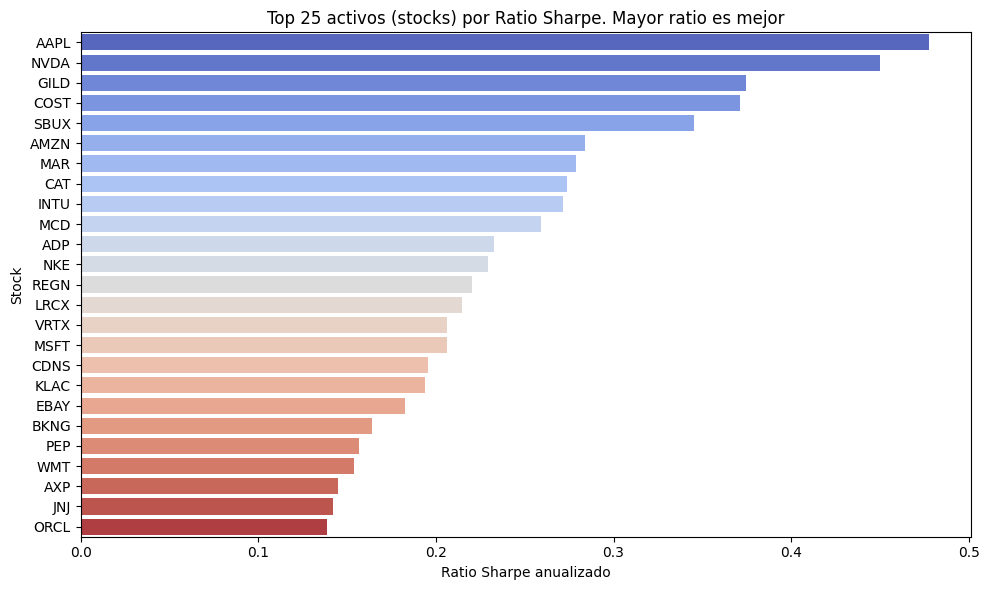

In [8]:

# Configuración de estilo para gráficos
 # Top 25 (excepto el índice GSPC) 
top_sharpe = stats[stats.index != '^GSPC'].sort_values('Sharpe', ascending=False).head(25)



plt.figure(figsize=(10, 6))
sns.barplot(y=top_sharpe.index, x=top_sharpe['Sharpe'], palette="coolwarm")
plt.xlabel('Ratio Sharpe anualizado')
plt.ylabel('Stock')
plt.title('Top 25 activos (stocks) por Ratio Sharpe. Mayor ratio es mejor')
plt.tight_layout()
plt.show()


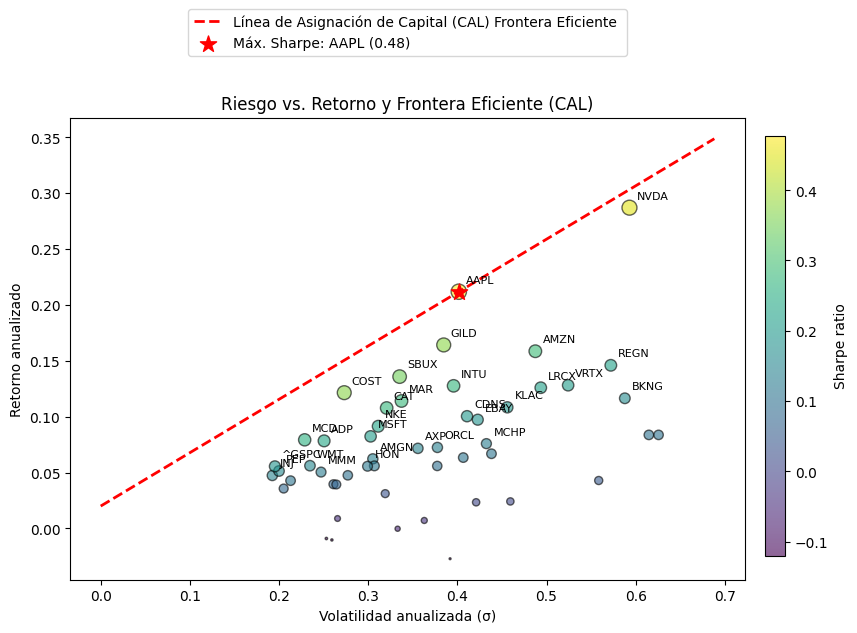

In [9]:
# Visualizamos el ratio Sharpe de todos los activos con Frontier de Sharpe

# Parámetros
rf = 0.02
max_sharpe = stats['Sharpe'].max()
best = stats['Sharpe'].idxmax()
best_vol = stats.loc[best, 'VolAnual']
best_ret = stats.loc[best, 'RetAnual']

# Datos de burbujas
x = stats['VolAnual']
y = stats['RetAnual']
sizes = (stats['Sharpe'] - stats['Sharpe'].min() + 0.01) * 200
colors = stats['Sharpe']

fig, ax = plt.subplots(figsize=(10,6))

# Scatter de burbujas
sc = ax.scatter(x, y,
                s=sizes,
                c=colors,
                cmap='viridis',
                alpha=0.6,
                edgecolor='k')

# Anotaciones top 30
for sym in stats['Sharpe'].nlargest(30).index:
    ax.text(x[sym]+0.008, y[sym]+0.008, sym, fontsize=8 )

# CAL (Sharpe frontier)
vol_line = np.linspace(0, x.max()*1.1, 100)
ret_line = rf + max_sharpe * vol_line
ax.plot(vol_line, ret_line, 'r--', lw=2, label='Línea de Asignación de Capital (CAL) Frontera Eficiente ')

# Estrella en el Sharpe máximo
ax.scatter(best_vol, best_ret,
           color='red', s=150, marker='*',
           label=f'Máx. Sharpe: {best} ({max_sharpe:.2f})')

ax.set_xlabel('Volatilidad anualizada (σ)')
ax.set_ylabel('Retorno anualizado')
ax.set_title('Riesgo vs. Retorno y Frontera Eficiente (CAL)')

# Ajustamos layout para dejar espacio a la derecha
fig.subplots_adjust(right=0.8)

# Colorbar ocupando el espacio sobrante
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Sharpe ratio')

# Leyenda arriba, centrada en el espacio libre
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1)

plt.show()


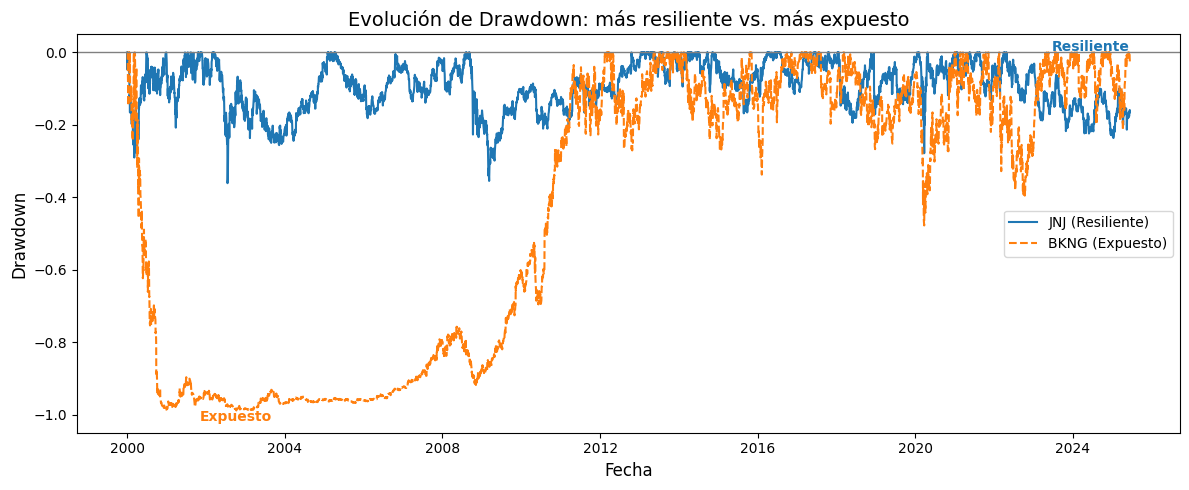

In [10]:
import matplotlib.pyplot as plt

# Identificar 1 más resiliente y 1 más expuesto
sorted_dd = stats['MaxDrawdown'].sort_values(ascending=False)
most_resilient = sorted_dd.head(1).index
most_exposed   = sorted_dd.tail(1).index

# Función de drawdown
def compute_drawdown(prices):
    roll_max = prices.cummax()
    return prices / roll_max - 1.0

plt.figure(figsize=(12, 5))

# Trazar el resiliente (línea continua, azul)
for sym in most_resilient:
    series = df[df['Symbol'] == sym].set_index('Fecha')['Close']
    dd = compute_drawdown(series)
    plt.plot(dd.index, dd, label=f"{sym} (Resiliente)", lw=1.5, color='#1f77b4')

# Trazar el expuesto (línea discontinua, naranja)
for sym in most_exposed:
    series = df[df['Symbol'] == sym].set_index('Fecha')['Close']
    dd = compute_drawdown(series)
    plt.plot(dd.index, dd, label=f"{sym} (Expuesto)", lw=1.5, ls='--', color='#ff7f0e')

# Línea base
plt.axhline(0, color='grey', lw=1)

# Etiquetas “in plot”
# Resiliente: último punto
x_r, y_r = dd.index[-1], dd.iloc[-1]
plt.text(x_r, y_r + 0.03, 'Resiliente', color='#1f77b4',
         fontsize=10, fontweight='bold', ha='right')

# Expuesto: punto más profundo
sym_exp = most_exposed[0]
series_exp = df[df['Symbol'] == sym_exp].set_index('Fecha')['Close']
dd_exp = compute_drawdown(series_exp)
idx_min = dd_exp.idxmin()
plt.text(idx_min, dd_exp.min() - 0.03, 'Expuesto', color='#ff7f0e',
         fontsize=10, fontweight='bold', ha='center')

# Título y ejes
plt.title('Evolución de Drawdown: más resiliente vs. más expuesto', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Drawdown', fontsize=12)
plt.ylim(-1.05, 0.05)

# Leyenda **dentro** del área, en la esquina superior derecha
leg = plt.legend(
    loc='center right',
    frameon=True,
    fontsize=10
)
leg.get_frame().set_edgecolor('lightgrey')
leg.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()


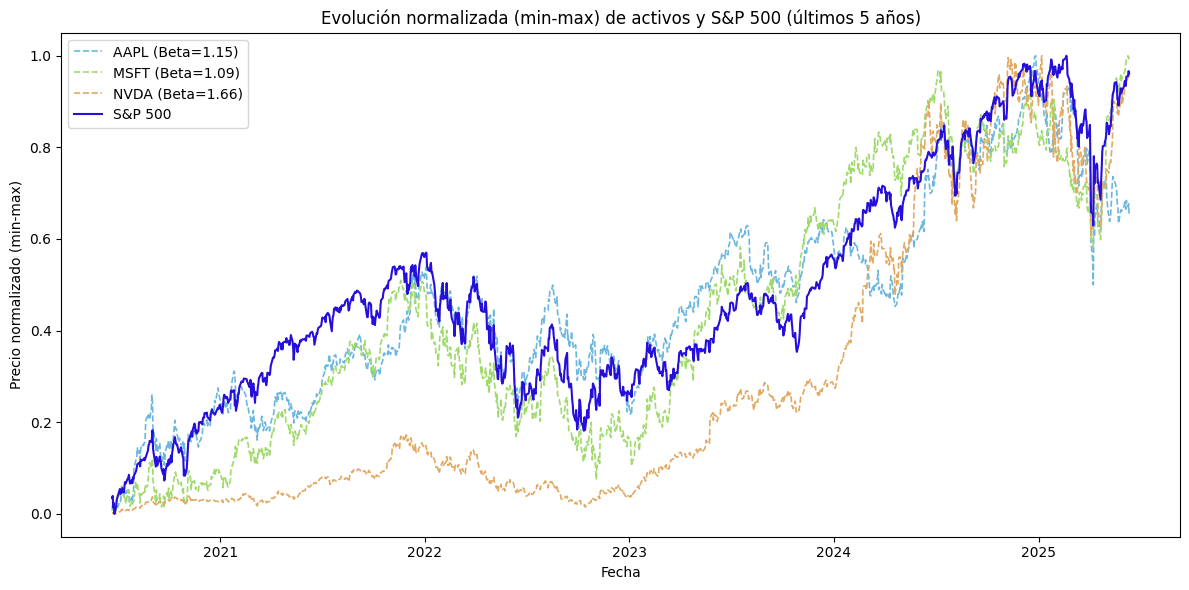

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Paleta de colores suaves (puedes cambiarla si quieres)
colores = ["#6DB7DE", "#A0DA6D", "#E1A961", "#B887D0", "#D87B8F"]

# Elige un color llamativo para el índice
color_indice = "#260FDA"  # Índice S&P 500

plt.figure(figsize=(12,6))

# Supongamos que ya tienes un DataFrame `df` con precios históricos
# Y que ya seleccionaste tus mejores activos

activos = ['AAPL', 'MSFT', 'NVDA']  # <- Lista de activos seleccionados
indice = '^GSPC'  # <- O el nombre que usas para el índice en `df`

# Normalizar precios (min-max) para todos
df_sel = df[df['Symbol'].isin(activos + [indice])].copy()
df_pivot = df_sel.pivot(index='Fecha', columns='Symbol', values='AdjClose')

# ✅ Filtrar últimos 5 años
fecha_min = pd.Timestamp.today() - pd.DateOffset(years=5)
df_pivot = df_pivot[df_pivot.index >= fecha_min]

# ✅ Normalizar después del filtro
prices_norm = (df_pivot - df_pivot.min()) / (df_pivot.max() - df_pivot.min())

# Suponiendo que ya tienes stats y prices_norm:
betas = stats['Beta'].to_dict()

# Graficar activos (líneas discontinuas, colores suaves)
for i, symbol in enumerate(activos):
    plt.plot(
        prices_norm.index, prices_norm[symbol],
        linestyle='--', color=colores[i % len(colores)],
        label=f"{symbol} (Beta={betas[symbol]:.2f})", linewidth=1.2
    )

# Graficar el índice (línea continua, más gruesa)
plt.plot(
    prices_norm.index, prices_norm[indice],
    color=color_indice, linestyle='-', linewidth=1.5, 
    label='S&P 500'
)

plt.title('Evolución normalizada (min-max) de activos y S&P 500 (últimos 5 años)')
plt.xlabel('Fecha')
plt.ylabel('Precio normalizado (min-max)')
plt.legend()
plt.tight_layout()
plt.show()


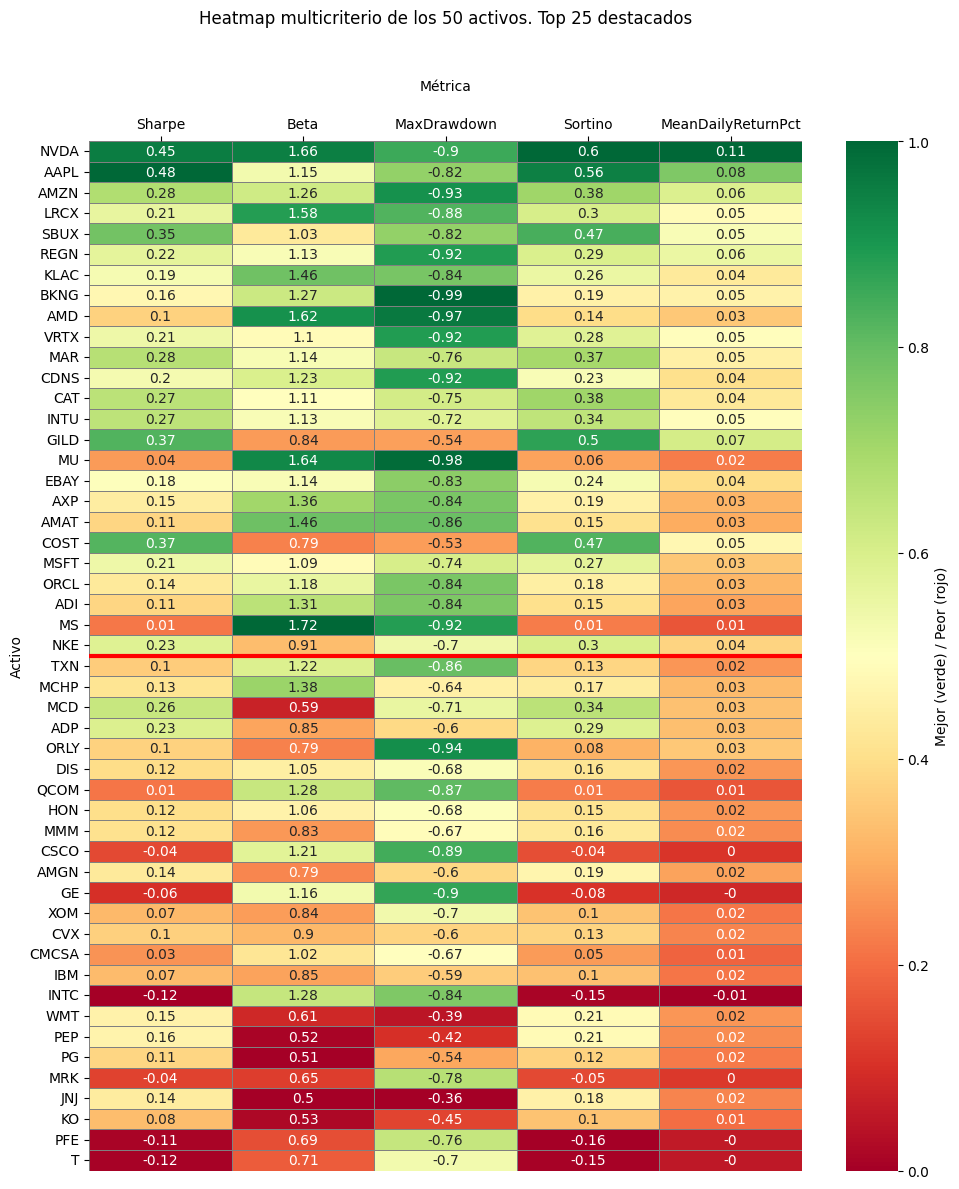

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Suponiendo que ya tienes el DataFrame 'stats' ---
# Debe tener las columnas: Symbol, Sharpe, Beta, MaxDrawdown, Sortino, MeanDailyReturn

# 1) Creamos MeanDailyReturnPct (retorno diario medio en %)
stats['MeanDailyReturnPct'] = stats['MeanDailyReturn'] * 100

# 2) Excluimos el índice de mercado si está (por ejemplo, "^GSPC")
stats = stats.drop('^GSPC', errors='ignore')

# 3) Ajustamos el signo de MaxDrawdown (menos drawdown es mejor)
stats['MaxDrawdownInv'] = -stats['MaxDrawdown']

# 4) Métricas y normalización [0,1]
metrics = ['Sharpe', 'Beta', 'MaxDrawdownInv', 'Sortino', 'MeanDailyReturnPct']
for m in metrics:
    stats[f'norm_{m}'] = (stats[m] - stats[m].min()) / (stats[m].max() - stats[m].min())

# 5) Índice compuesto (CompositeScore): media simple de las métricas normalizadas
stats['CompositeScore'] = stats[[f'norm_{m}' for m in metrics]].mean(axis=1)

# 6) Ordenamos y seleccionamos los 50 mejores
stats_sorted = stats.sort_values('CompositeScore', ascending=False).head(50)

# 7) Creamos tabla de métricas originales (para mostrar en heatmap)
heatmap_data = stats_sorted[['Sharpe', 'Beta', 'MaxDrawdown', 'Sortino', 'MeanDailyReturnPct']]

output_path = Path.cwd() / "DATA" / "tabla_heatmap_seleccion_stocks.csv"
heatmap_data.to_csv(output_path)


# 8) Normalizamos todas las métricas para el heatmap (MaxDrawdown invertido)
heatmap_data_norm = heatmap_data.copy()
heatmap_data_norm['MaxDrawdown'] = -heatmap_data_norm['MaxDrawdown']  # invertimos para que menos sea mejor
for col in heatmap_data_norm.columns:
    min_val = heatmap_data_norm[col].min()
    max_val = heatmap_data_norm[col].max()
    heatmap_data_norm[col] = (heatmap_data_norm[col] - min_val) / (max_val - min_val)

# 9) Hacemos heatmap. Destacamos los 25 mejores (primeros 25 del DataFrame ya ordenado)
plt.figure(figsize=(10, 12))
ax = sns.heatmap(
    heatmap_data_norm,
    cmap='RdYlGn',  # Verde = mejor, Rojo = peor
    annot=heatmap_data.round(2),  # Valores originales, redondeados
    fmt='g',
    linewidths=0.4,
    linecolor='grey',
    cbar_kws={'label':'Mejor (verde) / Peor (rojo)'}
)

# Dibuja una línea horizontal para destacar el corte en los 25 mejores
ax.hlines(25, *ax.get_xlim(), colors='red', linewidth=3)

# Métricas arriba
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlabel('Métrica', labelpad=20)
ax.set_ylabel('Activo')
plt.title('Heatmap multicriterio de los 50 activos. Top 25 destacados', pad=40)
plt.tight_layout()
plt.show()
